# Compare LOOCV and GCV on Pollution Dataset

## Import dependencies

In [1]:
import numpy as np
import pandas as pd
import peak_engines
import scipy
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Load the pollution dataset
The data is from
> McDonald and Schwing (1973), "Instabilities of Regression Estimates Relating Air Pollution to Mortality," Technometrics, 15, 463-481

and is available at [NCSU](https://www4.stat.ncsu.edu/~boos/var.select/pollution.html).

In [2]:
df = pd.read_csv('pollution.tsv', 
                 header=0, delim_whitespace=True)
X = np.array(df.iloc[:, :-1].values, dtype=float)
y = np.array(df.iloc[:,-1].values, dtype=float)
X = StandardScaler().fit_transform(X)

## Fit a ridge regression model so as to mimize the LOOCV error

In [3]:
loocv_alpha_best = peak_engines.RidgeRegressionModel(score='loocv').fit(X, y).alpha_
gcv_alpha_best = peak_engines.RidgeRegressionModel(score='gcv').fit(X, y).alpha_
print("loocv_alpha_best = ", loocv_alpha_best)
print("gcv_alpha_best = ", gcv_alpha_best)

loocv_alpha_best =  8.437006486935175
gcv_alpha_best =  7.095235374911837


## Compute GCV

In [4]:
def compute_l_matrix(X, alpha):
    R = scipy.linalg.qr(X, mode='r')[0]
    E = np.dot(np.conj(R.T), R) + np.diag(alpha)
    return np.linalg.cholesky(E)

In [5]:
def compute_ridge_regression_prediction(X, y, alpha, X_test):
    z = np.dot(np.conj(X.T), y)
    L = compute_l_matrix(X, alpha)
    beta = scipy.linalg.solve_triangular(L, z, lower=True)
    beta = scipy.linalg.solve_triangular(np.conj(L.T), beta, lower=False)
    return np.dot(X_test, beta)

In [6]:
def compute_loocv_impl(X, y, alpha):
    result = 0
    for train_indexes, test_indexes in LeaveOneOut().split(X):
        X_train, X_test = X[train_indexes], X[test_indexes]
        y_train, y_test = y[train_indexes], y[test_indexes]
        y_pred = compute_ridge_regression_prediction(X_train, y_train, alpha, X_test)
        result += np.abs(y_test[0] - y_pred[0])**2
    return result / len(y)

In [7]:
def compute_loocv(X, y, alpha, fit_intercept=True):
    n, k = X.shape
    if fit_intercept:
        alpha = np.array([alpha]*k + [0])
        X = np.hstack((X, np.ones((n, 1))))
        k +=1
    else:
        alpha = np.ones(k)*alpha
    return compute_loocv_impl(X, y, alpha)

In [8]:
def compute_gcv(X, y, alpha, fit_intercept=True):
    n, k = X.shape
    if fit_intercept:
        alpha = np.array([alpha]*k + [0])
        X = np.hstack((X, np.ones((n, 1))))
        k +=1
    else:
        alpha = np.ones(k)*alpha
    U, S, Vt = np.linalg.svd(X)
    S = np.vstack((np.diag(S), np.zeros((n-k, k))))
    # Note: the rotation for GCV can be computed much more efficiently with a FFT, but this 
    # keeps things simple.
    W = np.array([[np.exp(2j*np.pi*i*j/n) / np.sqrt(n) for j in range(n)] for i in range(n)])
    X_prime = np.dot(W, np.dot(S, Vt))
    y_prime = np.dot(W, np.dot(U.T, y))
    return compute_loocv_impl(X_prime, y_prime, alpha)

In [9]:
print(compute_gcv(X, y, gcv_alpha_best - 0.01))
print(compute_gcv(X, y, gcv_alpha_best))
print(compute_gcv(X, y, gcv_alpha_best + 0.01))

1522.474621462299
1522.4745400263112
1522.4746213065278


In [10]:
print(compute_loocv(X, y, loocv_alpha_best - 0.01))
print(compute_loocv(X, y, loocv_alpha_best))
print(compute_loocv(X, y, loocv_alpha_best + 0.01))

1631.3586290652643
1631.3585649228833
1631.3586289531474


## Plot the LOOCV error for different values of alpha

In [11]:
alphas = np.arange(0.1, 20, .1)
loocv_scores = [compute_loocv(X, y, alpha) for alpha in alphas]
gcv_scores = [compute_gcv(X, y, alpha) for alpha in alphas]

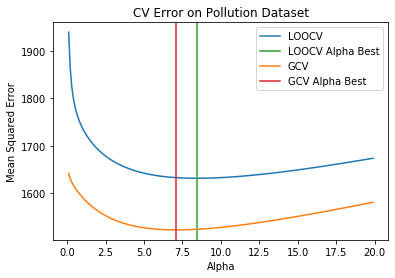

In [12]:
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.plot(alphas, loocv_scores, label='LOOCV')
plt.axvline(loocv_alpha_best, color='tab:green', label='LOOCV Alpha Best')
plt.plot(alphas, gcv_scores, label='GCV')
plt.axvline(gcv_alpha_best, color='tab:red', label='GCV Alpha Best')
plt.title('CV Error on Pollution Dataset')
plt.legend(loc='upper right')

In [13]:
model = RidgeCV(list(alphas) + [loocv_alpha_best, gcv_alpha_best])
model.fit(X, y)
print(model.alpha_, loocv_alpha_best)
print(model.best_score_, compute_loocv(X, y, loocv_alpha_best))

8.437006486935175 8.437006486935175
-1631.3585649228744 1631.3585649228833
